### IMPORTS

In [1]:
from __future__ import annotations

# Standard library
from pathlib import Path
from typing import TYPE_CHECKING
from dataclasses import dataclass
from itertools import chain

import networkx as nx

# Third-party libraries
import numpy as np
from rich.console import Console

# Local libraries

if TYPE_CHECKING:
    from collections.abc import Generator

# Global constants
# SCRIPT_NAME = __file__.split("/")[-1][:-3]
SCRIPT_NAME = "canical_test"
CWD = Path.cwd()
DATA = Path(CWD / "__data__" / SCRIPT_NAME)
DATA.mkdir(exist_ok=True, parents=True)
SEED = 42

# Global functions
console = Console()
console.is_jupyter = False
RNG = np.random.default_rng(SEED)


from builtins import type as create_class
from enum import Enum
from typing import Any

from ariel.body_phenotypes.robogen_lite.config import (
    ALLOWED_FACES,
    ModuleFaces,
    ModuleInstance,
    ModuleRotationsIdx,
    ALLOWED_ROTATIONS,
    ModuleType,
)

# * IT IS SUPER VERY IMPORTANT THAT MODULEFACES ORDER NEVER CHANGES<3

### CONFIG

In [2]:
class SymmetryPlane(Enum):
    """Symmetry plane determines how many unique rotations a module has."""

    NONE = 1
    TWO_FOLD = 2
    FOUR_FOLD = 4


class Priority(Enum):
    FIRST = 3
    SECOND = 2
    THIRD = 1
    FOURTH = 0


class DIRECTION(Enum):
    CLOCKWISE = -1
    COUNTERCLOCKWISE = 1


ROTATION_DIRECTION = DIRECTION.CLOCKWISE.value  # TODO: broken...


@dataclass(frozen=True)
class ModuleCanonicalConfig:
    """Pre-computed canonical configuration for a module type."""

    symmetry_plane: SymmetryPlane
    max_allowed_rotations: int
    priority: Priority
    axial_face_order: tuple[ModuleFaces, ...]
    radial_face_order: tuple[ModuleFaces, ...]

    @classmethod
    def create(
        cls,
        module_type: ModuleType,
        attachment_face: ModuleFaces | None,
        symmetry_plane: SymmetryPlane,
        allowed_rotations: list[ModuleRotationsIdx],
        priority: Priority,
    ) -> "ModuleCanonicalConfig":
        """Factory method to create a config with computed face orders."""
        axial_face_order, radial_face_order = cls._compute_face_indices(
            module_type, attachment_face
        )

        max_allowed_rotations = cls._compute_max_allowed_rotations(
            allowed_rotations, symmetry_plane
        )

        return cls(
            symmetry_plane=symmetry_plane,
            max_allowed_rotations=max_allowed_rotations,
            priority=priority,
            axial_face_order=axial_face_order,
            radial_face_order=radial_face_order,
        )

    @staticmethod
    def _compute_max_allowed_rotations(
        allowed_rotations: list[ModuleRotationsIdx],
        symmetry_plane: SymmetryPlane,
    ) -> int:
        """Calculate max allowed rotations based on symmetry."""
        result = len(allowed_rotations) // symmetry_plane.value
        return result if result != 0 else symmetry_plane.value

    @staticmethod
    def _compute_face_indices(
        module_type: ModuleType,
        attachment_face: ModuleFaces | None,
    ) -> tuple[tuple[ModuleFaces, ...], tuple[ModuleFaces, ...]]:
        """Compute axial and radial face orders based on attachment face."""
        if not attachment_face:
            axial_pair = {ModuleFaces.TOP, ModuleFaces.BOTTOM}
        else:
            axial_pair = {
                attachment_face,
                ModuleFaces(attachment_face.value ^ 1),
            }

        # Filter to only allowed faces
        reduced_axial = axial_pair & set(ALLOWED_FACES[module_type])
        axial_face_order = tuple(sorted(reduced_axial, key=lambda f: f.value))

        # Compute radial faces (all faces except axial pair)
        radial_list = set(ALLOWED_FACES[module_type]).difference(axial_pair)

        # Reorder radial faces: [0,1,2,3] -> [0,2,1,3] then apply rotation direction
        radial_face_order = tuple(
            (lambda s: s[:1] + s[2:3] + s[1:2] + s[3:])(
                sorted(radial_list, key=lambda f: f.value),
            )[::ROTATION_DIRECTION]
        )

        # console.print(module_type, radial_face_order) # todo test

        return axial_face_order, radial_face_order


# Pre-define configurations for each module type
CANONICAL_CONFIGS: dict[ModuleType, ModuleCanonicalConfig] = {
    ModuleType.CORE: ModuleCanonicalConfig.create(
        module_type=ModuleType.CORE,
        attachment_face=None,
        symmetry_plane=SymmetryPlane.FOUR_FOLD,
        allowed_rotations=ALLOWED_ROTATIONS[ModuleType.CORE],
        priority=Priority.FIRST,
    ),
    ModuleType.BRICK: ModuleCanonicalConfig.create(
        module_type=ModuleType.BRICK,
        attachment_face=ModuleFaces.BACK,
        symmetry_plane=SymmetryPlane.FOUR_FOLD,
        allowed_rotations=ALLOWED_ROTATIONS[ModuleType.BRICK],
        priority=Priority.SECOND,
    ),
    ModuleType.HINGE: ModuleCanonicalConfig.create(
        module_type=ModuleType.HINGE,
        attachment_face=ModuleFaces.BACK,
        symmetry_plane=SymmetryPlane.TWO_FOLD,
        allowed_rotations=ALLOWED_ROTATIONS[ModuleType.HINGE],
        priority=Priority.THIRD,
    ),
    ModuleType.NONE: ModuleCanonicalConfig.create(
        module_type=ModuleType.NONE,
        attachment_face=ModuleFaces.BACK,
        symmetry_plane=SymmetryPlane.NONE,
        allowed_rotations=[ModuleRotationsIdx.DEG_0],
        priority=Priority.FOURTH,
    ),
}

### CLASS

In [3]:
from typing import Any, Generator

from ariel.body_phenotypes.robogen_lite.config import ModuleFaces


class CanonicalNode:
    _id_counter = 0

    def __init__(
        self,
        module_type: ModuleType | str,
        rotation: int = 0,
        *,
        parent: CanonicalNode | None = None,
        config: ModuleCanonicalConfig | None = None,
        node_id: int | None = None,
    ) -> None:
        if isinstance(module_type, str):
            module_type = ModuleType[module_type.upper()]

        if config is None:
            config = CANONICAL_CONFIGS[module_type]

        if node_id is None:
            node_id = CanonicalNode._id_counter
            CanonicalNode._id_counter += 1

        self.module_type = module_type
        self.rotation = rotation
        self.node_id = node_id
        self.parent = parent

        self._symmetry_plane = config.symmetry_plane.value
        self._max_allowed_rotatations = config.max_allowed_rotations
        self._priority = config.priority.value
        self._full_priority = config.priority.value

        # List where children get stored and the face type mapping
        self._axial_face_order = config.axial_face_order
        self._radial_face_order = config.radial_face_order
        self._axial_list: list[None | CanonicalNode] = [None] * len(
            config.axial_face_order
        )
        self._radial_list: list[None | CanonicalNode] = [None] * len(
            config.radial_face_order
        )

    # region helpers

    def _get_face_index(self, face_name: str) -> tuple[str, int] | None:
        try:
            face = ModuleFaces[face_name.upper()]
            if face in self._axial_face_order:
                return ("_axial_list", self._axial_face_order.index(face))
            if face in self._radial_face_order:
                return ("_radial_list", self._radial_face_order.index(face))

            raise ValueError(
                f"Face '{face.name}' not allowed for {self.module_type.name}.\n"
                f"Allowed axial: {[f.name for f in self._axial_face_order]}\n"
                f"Allowed radial: {[f.name for f in self._radial_face_order]}"
            )
        except KeyError:
            return None  # Not a face at all

    def _copy_subtree(self) -> "CanonicalNode":
        # Create a copy of this node with a new ID
        new_node = CanonicalNode(
            module_type=self.module_type,
            rotation=self.rotation,
            node_id=None,  # Will get a new auto-generated ID
        )
        new_node.parent = None  # Clear parent
        new_node._full_priority = self._full_priority  # Copy priority state
        
        # Recursively copy children
        for face, child in self.children:
            if child is not None:
                child_copy = child._copy_subtree()
                new_node[face] = child_copy
        
        return new_node

    # Region dunder methods
    def __getattr__(self, name: str) -> CanonicalNode | None:
        try:
            result = self._get_face_index(name)
            if result is not None:
                list_name, index = result
                return getattr(self, list_name)[index]
        except ValueError:
            raise  # Re-raise for non-allowed faces
        raise AttributeError(
            f"'{self.__class__.__name__}' has no attribute '{name}'"
        )

    def __setattr__(self, name: str, child_node) -> None:
        try:
            result = self._get_face_index(name)
        except ValueError as e:
            raise ValueError(str(e)) from None  # Suppress traceback chaining

        if result is not None:
            list_name, index = result
            if isinstance(child_node, CanonicalNode):
                
                if child_node.parent:
                    child_node = child_node._copy_subtree()
                    
                child_node.parent = self
                node = self           
                while node:
                    node._full_priority += child_node._priority
                    node = node.parent
            else:
                raise ValueError("Trying to add a non CanonicalNode object")

            getattr(self, list_name)[index] = child_node
        else:
            object.__setattr__(self, name, child_node)

    def __setitem__(self, face: ModuleFaces, child: CanonicalNode) -> None:
        setattr(self, face.name, child)

    def __getitem__(self, face: ModuleFaces) -> CanonicalNode | None:
        return getattr(self, face.name)

    # TODO: make use of the rich tree print thing
    def __str__(self, level: int = 0) -> str:
        """
        Return a formatted string representation of the CanonicalNode object.

        Parameters
        ----------
        level : int, default 0
            Indentation level for nested string formatting.

        Returns
        -------
        str
            Multi-line formatted string showing node attributes and children.

        Notes
        -----
        - Creates hierarchical indentation using 2 spaces per level
        - Shows _axial_list children only for faces in ALLOWED_FACES[self.type]
        - Shows _radial_list children for all faces in ALLOWED_FACES[self.type]
        - Displays 'None' for missing child nodes at each face position
        """
        indent = "    " * level

        # Start with basic attributes
        attributes = [
            f"{indent}id={self.node_id}",
            f"{indent}type={self.module_type.name}",
            f"{indent}rotation={self.rotation}",
            # f"{indent}symmetry_plane={self._symmetry_plane}",
        ]

        # Add axial children
        axial_children = ",\n".join(
            f"{indent}  {face.name}: {getattr(self, face.name).__str__(level + 1)}"
            if getattr(self, face.name) is not None
            else f"{indent}  {face.name}: None"
            for face in self._axial_face_order  # Instance-specific
        )
        attributes.append(
            f"{indent}axial_side=[\n{axial_children or f'{indent}  None'}\n{indent}]",
        )

        # Add radial children
        radial_children = ",\n".join(
            f"{indent}  {face.name}: {getattr(self, face.name).__str__(level + 1)}"
            if getattr(self, face.name) is not None
            else f"{indent}  {face.name}: None"
            for face in self._radial_face_order  # Instance-specific
        )
        attributes.append(
            f"{indent}radial_side=[\n{radial_children or f'{indent}  None'}\n{indent}]",
        )

        # Format the final string iteratively
        formatted_attributes = "\n".join(attributes)
        return f"{indent}CanonicalNode(\n{formatted_attributes}\n{indent})"

    def __repr__(self) -> str:
        """
        Return a string representation of the object.

        Returns
        -------
        str
            A compact string representation showing type, rotation, and children.

        Notes
        -----
        - Format: "{type_initial}{rotation}[{face_children}]"
        - Type initial is first character of self.type.name
        - Rotation only included if non-zero
        - Face children shown as "{face_initial}:{child_repr}"
        - Empty brackets omitted if no children exist
        """
        repr_str = f"{self.module_type.name[0]}"
        if self.rotation != 0:
            repr_str += f"{int(self.rotation)}"
        repr_str += "{"

        children_repr = []
        for face in self._axial_face_order + self._radial_face_order:
            child = getattr(self, face.name)
            if child:
                children_repr.append(f"{face.name.lower()[0]}:{child!r}")
        repr_str += "".join(children_repr)
        repr_str += "}"
        return repr_str

    def __iter__(
        self,
    ) -> Generator[tuple[ModuleFaces, CanonicalNode], None, None]:
        """Allows iteration over (face, child) pairs for all non-None children."""
        yield from self.children

    # endregion

    # region properties
    @property
    def children(self) -> Generator[tuple[ModuleFaces, CanonicalNode], Any, None]:
        """Yields (face, child) tuples for all non-None children."""
        for face, child in chain(
            zip(self._axial_face_order, self._axial_list),
            zip(self._radial_face_order, self._radial_list),
        ):
            if child is not None:
                yield (face, child)

    @property
    def axial_children(self) -> Generator[CanonicalNode, Any, None]:
        for child in self._axial_list:
            if child is not None:
                yield child

    @property
    def radial_children(self) -> Generator[CanonicalNode, Any, None]:
        for child in self._radial_list:
            if child is not None:
                yield child

    # endregion

    # region construction
    @classmethod
    def new_root(
        cls, module_type: ModuleType = ModuleType.CORE, **kwargs
    ) -> "CanonicalNode":
        """Create a new root with ID counter starting at 0."""
        cls._id_counter = 0
        return cls(module_type=module_type, **kwargs)

    @classmethod
    def from_graph(
        cls,
        graph: nx.DiGraph[Any],
        skip_type: ModuleType = ModuleType.NONE,
    ) -> CanonicalNode:
        """Build a CanonicalNode tree from a NetworkX graph."""

        # TODO: check typing
        def get_rotation_value(rotation_attr):
            return (
                ModuleRotationsIdx[rotation_attr].value
                if isinstance(rotation_attr, str)
                else rotation_attr
            )

        def create_node(
            node_id: int,
        ) -> CanonicalNode:
            attrs = graph.nodes[node_id]
            return CanonicalNode(
                module_type=ModuleType[attrs["type"]],
                rotation=get_rotation_value(attrs["rotation"]),
                node_id=node_id,
                # _parent_id=_parent.node_id,
            )

        def fill_in(_parent: CanonicalNode) -> None:
            for _, child_id, edge_data in graph.out_edges(
                _parent.node_id, data=True
            ):
                child_type = ModuleType[graph.nodes[child_id]["type"]]

                if child_type == skip_type:
                    continue

                child = create_node(child_id)
                _parent[ModuleFaces[edge_data["face"]]] = child
                fill_in(child)

        root_id = next(
            node for node in graph.nodes() if graph.in_degree(node) == 0
        )
        root = create_node(root_id)
        fill_in(root)

        return root

    @classmethod
    def from_dict(
        cls,
        data: dict[int, ModuleInstance],
        omit_none: bool = False,
    ) -> CanonicalNode:
        root = CanonicalNode.new_root()

        def fill_in(data: dict[int, ModuleType], parent: CanonicalNode) -> None:
            for face, node_id in data[parent.node_id].links.items():
                # if omit_none and data[node_id].type == ModuleType.NONE:
                #     continue
                child = CanonicalNode(
                    module_type=data[node_id].type,
                    # _parent_id=_parent.id,
                    rotation=data[node_id].rotation.value,
                    node_id=node_id,
                )
                parent[face] = child
                fill_in(data, child)

        fill_in(data, root)
        return root

    # endregion

    # region conversion

    def to_dict(self, *, omit_none: bool = False) -> dict[int, ModuleInstance]:
        result = {}

        def collect_node(node: CanonicalNode) -> None:
            if omit_none and node.module_type == ModuleType.NONE:
                return

            links = {}
            for face, child in node:
                if not omit_none or child.module_type != ModuleType.NONE:
                    links[face] = child.node_id

            result[node.node_id] = ModuleInstance(
                type=node.module_type,
                rotation=ModuleRotationsIdx(node.rotation),
                links=links,
            )

            for _, child in node.children:
                collect_node(child)

        collect_node(self)
        return result

    # TODO; is this cursed to have in the arguments?
    def to_graph(
        self, *, skip_type: ModuleType = ModuleType.NONE
    ) -> nx.DiGraph[Any]:
        """Generate a NetworkX graph from the CanonicalNode tree."""
        graph = nx.DiGraph()

        def traverse_node(node: CanonicalNode) -> None:
            graph.add_node(
                node.node_id,
                type=node.module_type.name,
                rotation=ModuleRotationsIdx(node.rotation).name,
            )

            for face, child in node.children:
                if child.module_type == skip_type:
                    print("found skyptype")  # Todo: check if this works well?
                    continue

                graph.add_node(
                    child.node_id,
                    type=child.module_type.name,
                    rotation=ModuleRotationsIdx(child.rotation).name,
                )
                graph.add_edge(
                    node.node_id,
                    child.node_id,
                    face=face.name,
                )
                traverse_node(child)

        traverse_node(self)
        return graph

    # endregion

    # TODO: need to fix this........ and think
    # def is_connected_to_axial_root(self) -> bool:
    #     if not hasattr(self, '_face_attached'):
    #         return False

    #     # Must be attached via FRONT to start the chain
    #     if self._face_attached != ModuleFaces.FRONT:
    #         return False

    #     console.print('_parent has face attached atribute ')
    #     # Check if _parent exists and is attached via TOP/BOTTOM, and grand_parent has _is_new_root
    #     if (self._parent and
    #         hasattr(self._parent, '_face_attached') and
    #         self._parent._face_attached in (ModuleFaces.TOP, ModuleFaces.BOTTOM) and
    #         self._parent._parent and
    #         self._parent._parent._is_new_root):
    #         return True

    #     # If not directly matching, recurse up the chain if _parent exists
    #     if self._parent:
    #         return self._parent.is_connected_to_axial_root()

    #     return False

    # TODO might add this if i want to account for symmetry in the hashing?..
    def invert_symmetry(self) -> None:
        pass

    def canonicalize_child_order(self) -> None:
        """
        uses the full priority to determine the child order
        always sets the max at first
        rotatation always in 1 direction
        """
        side_amt = len(self._radial_list)
        if side_amt == 0:
            return

        priority_list = []
        for child in self._radial_list:
            if child is None:
                priority_list.append(0)
            else:
                priority_list.append(child._full_priority)

        max_index = priority_list.index(max(priority_list))
        num_rotations = (side_amt - max_index) % side_amt
        for _ in range(num_rotations):
            self.rotate()

    def rotate(self):
        self.rotation = self.rotation - self._max_allowed_rotatations
        self._radial_list[:] = self._radial_list[-1:] + self._radial_list[:-1]

        # account for axial child rotation
        for child in self.axial_children:
            child.rotation += self._max_allowed_rotatations

        # if self._parent and self._parent._is_new_root:
        #     console.print(self.is_connected_to_axial_root(), self.id)
        # # if self.is_connected_to_axial_root():
        #     # this means this is either the top or the bottom
        #     # right, bottom, left, top
        #     SHIFTS_PER_PLACE = {0: 1, 1: 1, 2: -1, 3: -1}

        #     for i, child in enumerate(self._radial_list):
        #         if child and len(child._radial_list) > 0:  # Add check for non-empty list
        #             shift = SHIFTS_PER_PLACE.get(i, 0)
        #             child._radial_list[:] = child._radial_list[shift:] + child._radial_list[:shift]
        #             console.print(i, repr(child))
        #             console.print('changed child: ', child.id)

        # if self._parent and self._parent._is_new_root:
        #     for i, child in enumerate(self._radial_list):
        #         if child:
        #             # place 0 (rn right) -> shift with 1

        #             # place 1 (rn bottom) -> shift with -3

        #             # place 3 (rn left) -> shift with -1

        #             # place 4 (rn top) -> shift with 3

        #             # LEFT
        #             console.print(i, repr(child))
        #             child._radial_list[:] = child._radial_list[3:] + child._radial_list[:3]

        # if a piece is the new root and the

        # account for top/bottom for the root
        # if self._is_new_root:
        #     if self.TOP:
        #         console.print('found a top')
        #         # recurse everything to front?
        #         top_child = self.TOP
        #         for child in top_child.radial_children:
        #             console.print('rotated child ,', repr(child))
        #             child._radial_list[:] = child._radial_list[1:] + child._radial_list[:1]

        #     if self.BOTTOM:
        #         bottom_child = self.BOTTOM
        #         console.print('found a bottom')
        #         for child in bottom_child.radial_children:
        #             console.print('rotated child ', repr(child))
        #             child._radial_list[:] = child._radial_list[1:] + child._radial_list[:1]

        # for grand_child in child.radial_children:
        #     console.print('found the radial child of the axial child')
        #     grand_child._radial_list[:] = grand_child._radial_list[-1:] + grand_child._radial_list[:-1]

    def normalize_rotations(self) -> None:
        swap_amt = self.rotation // self._max_allowed_rotatations

        for _ in range(swap_amt):
            console.print(f'rotating {self.node_id}')
            self.rotate()

        for _, child in self.children:
            child.normalize_rotations()

    # def fix_new_root(self):
    #     for child in self.axial_children:
    #         console.print('found axial children:', repr(child))
    #         # for grand_child in child.radial_children:
    #         # child.LEFT:
    #         child.LEFT._radial_list[:] = child.LEFT._radial_list[-1:] + child.LEFT._radial_list[:-1]
    #         console.print('decreased the ggrand child rotaion')
    #         # child.RIGHT:
    #         child.RIGHT._radial_list[:] =  child.RIGHT._radial_list[-2:] + child.RIGHT._radial_list[:-2]

    def re_add_id(self, start_id: int = 0) -> int:
        self.node_id = start_id
        current_id = start_id + 1
        for child in self.children_nodes:
            current_id = child.re_add_id(current_id)
        return current_id

    def canonicalize(self) -> CanonicalNode:
        # self.canonicalize_child_order()
        self.normalize_rotations()
        return self

    def depth_first_collect(self) -> list[nx.DiGraph[Any]]:
        list_graph = []

        self._is_new_root = True
        # self.canonicalize_child_order()
        self.rotation = 0
        self.normalize_rotations()
        self.re_add_id()
        self._is_new_root = False

        list_graph.append(self.to_graph())

        for child in self.children_nodes:
            list_graph.extend(child.depth_first_collect())

        return list_graph

---

In [4]:
from ariel_experiments.gui_vis.visualize_tree import (
    visualize_tree_from_graph,
)

# from ariel_experiments.utils.initialize import generate_random_individual
from ariel_experiments.gui_vis.view_mujoco import view


console.is_jupyter = False  # makes the print output from rich more compact
%matplotlib inline


### Class usage demonstration

Face 'LEFT' not allowed for HINGE.
Allowed axial: ['FRONT']
Allowed radial: []
{
    0: ModuleInstance(
        type=<ModuleType.CORE: 0>,
        rotation=<ModuleRotationsIdx.DEG_0: 0>,
        links={
            <ModuleFaces.TOP: 4>: 1,
            <ModuleFaces.BOTTOM: 5>: 6,
            <ModuleFaces.LEFT: 3>: 2,
            <ModuleFaces.BACK: 1>: 9
        }
    ),
    1: ModuleInstance(type=<ModuleType.BRICK: 1>, rotation=<ModuleRotationsIdx.DEG_0: 0>, links={}),
    6: ModuleInstance(
        type=<ModuleType.HINGE: 2>,
        rotation=<ModuleRotationsIdx.DEG_0: 0>,
        links={<ModuleFaces.FRONT: 0>: 7}
    ),
    7: ModuleInstance(
        type=<ModuleType.BRICK: 1>,
        rotation=<ModuleRotationsIdx.DEG_0: 0>,
        links={<ModuleFaces.LEFT: 3>: 8}
    ),
    8: ModuleInstance(type=<ModuleType.BRICK: 1>, rotation=<ModuleRotationsIdx.DEG_135: 3>, links={}),
    2: ModuleInstance(
        type=<ModuleType.HINGE: 2>,
        rotation=<ModuleRotationsIdx.DEG_0: 0>,
      

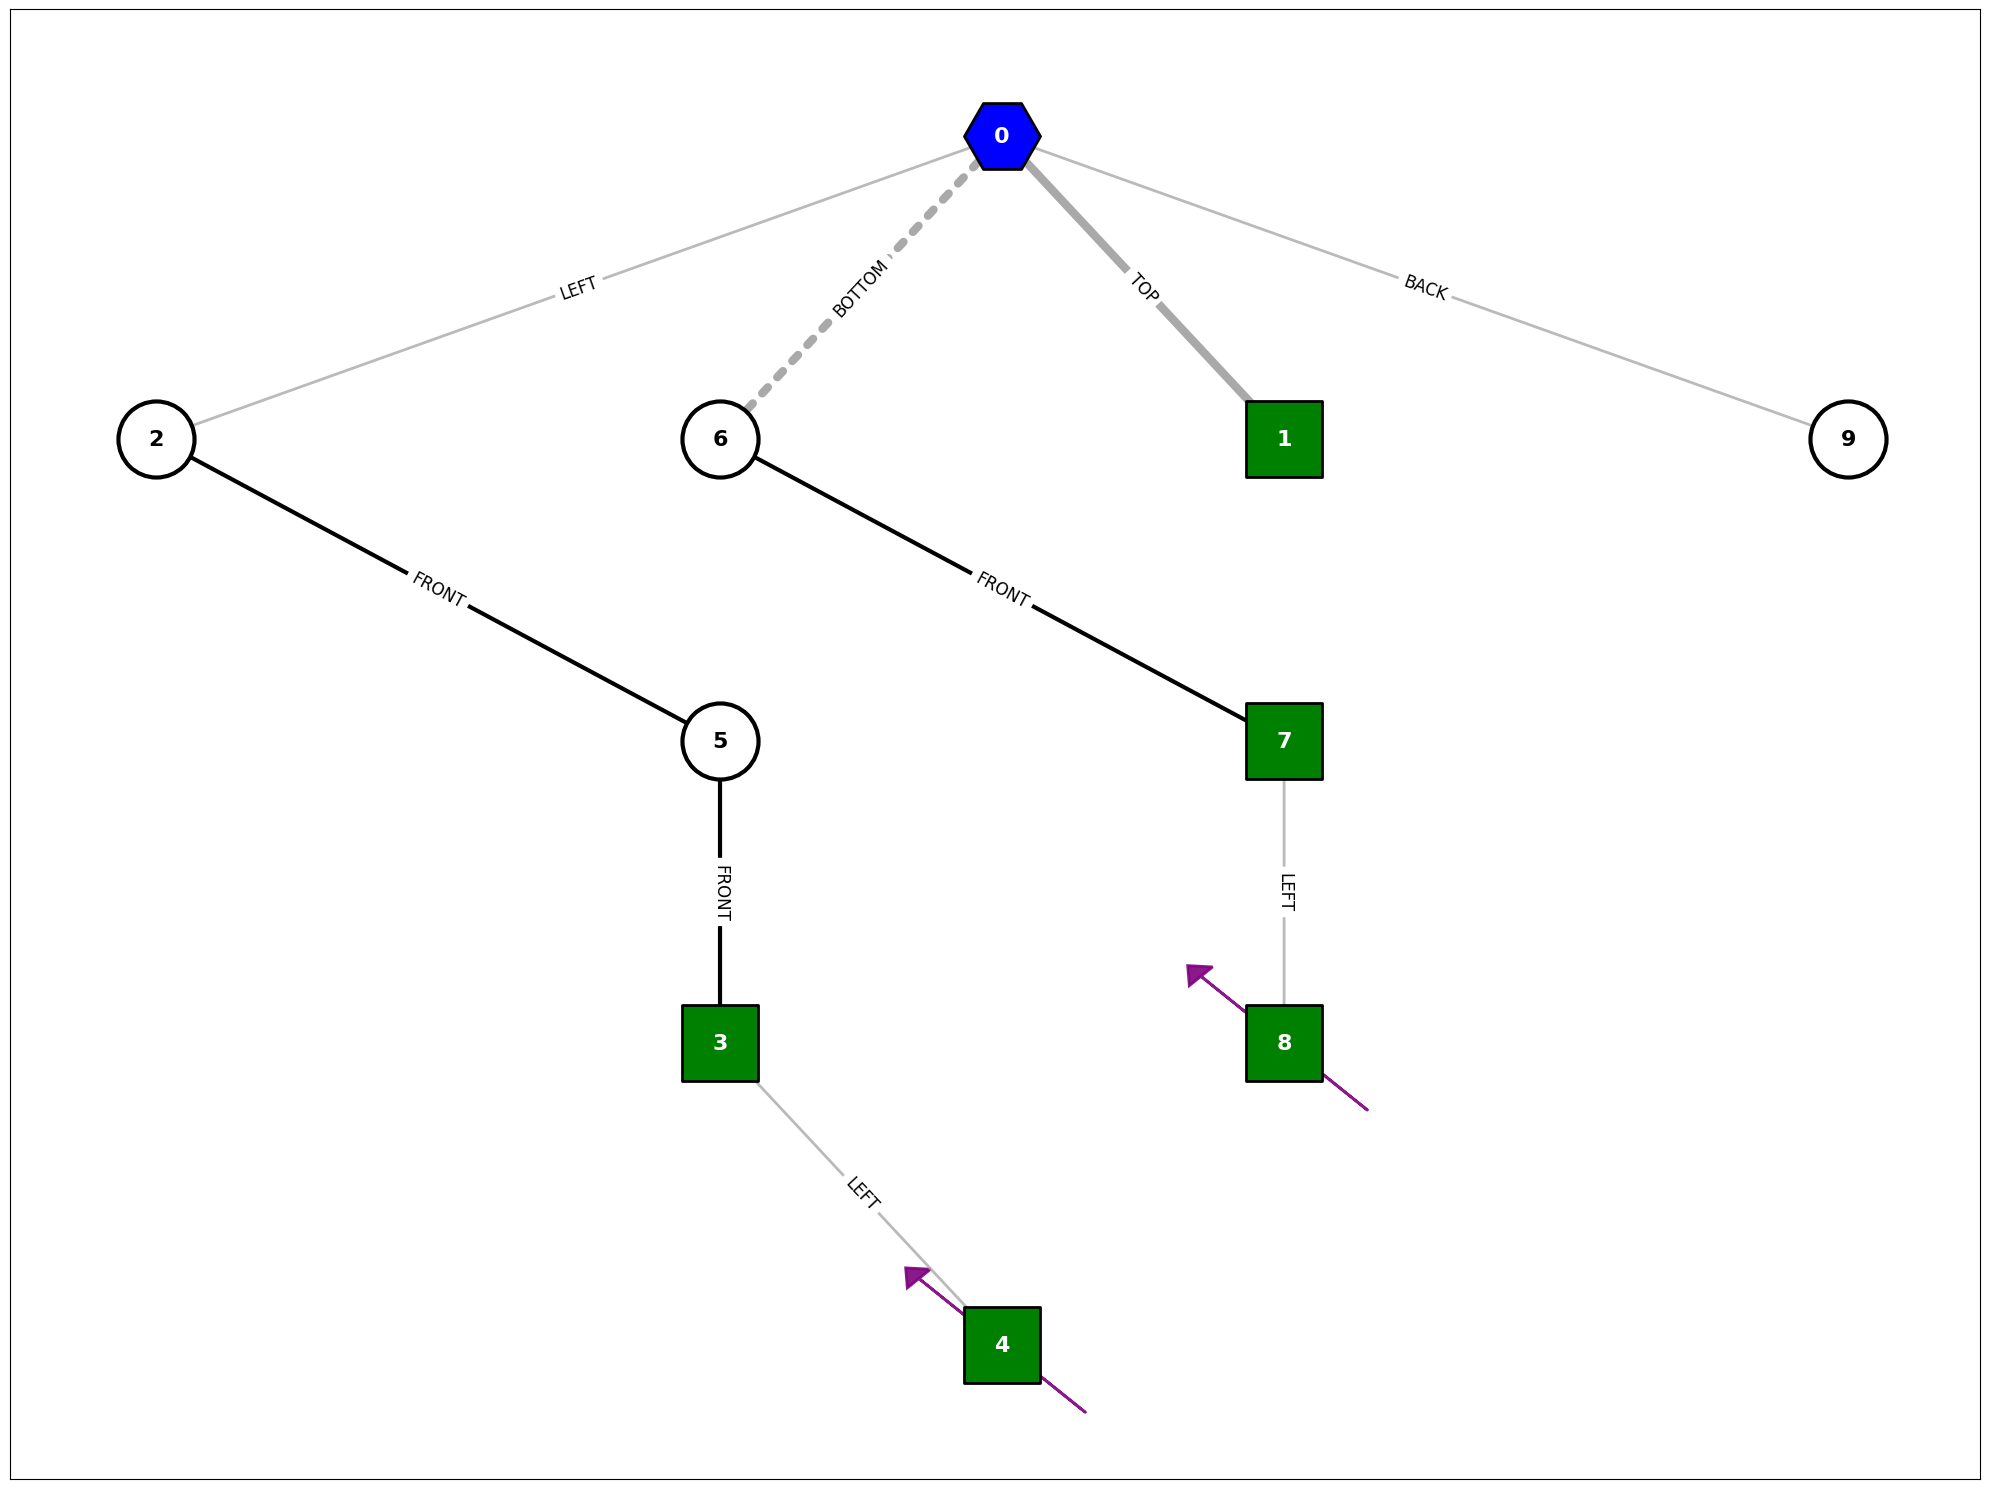

[23:56:10] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=785663;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=883768;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

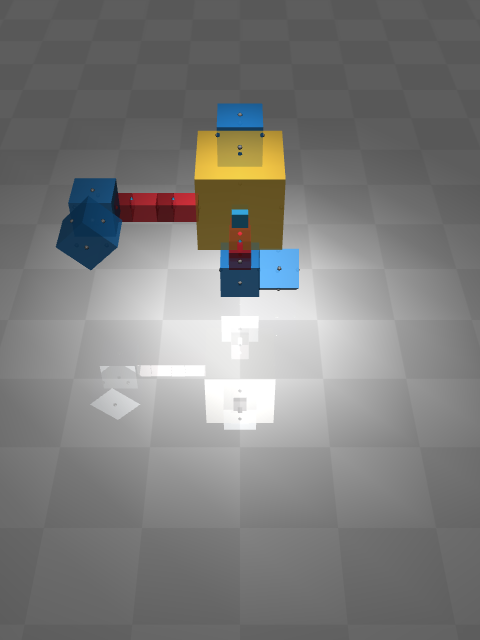

In [5]:
# Create self!
diy_root = CanonicalNode.new_root()
diy_root.TOP = CanonicalNode(ModuleType.BRICK)  # you can add a module like this
diy_root.LEFT = CanonicalNode(
    "HINGE"
)  # or by simply typing (can also be lowercase)

# you can create modules first and stich them together
brick = CanonicalNode("brick")  
brick2 = CanonicalNode("brick", 3)  # add rotation
brick.LEFT = brick2
hinge = CanonicalNode("hinge")
hinge.FRONT = brick

# you can also acces like a chain
diy_root.LEFT.FRONT = hinge

# when adding a chain a second time, a copy of the chain gets added:
diy_root.BOTTOM = hinge


hinge2 = CanonicalNode("hinge")
diy_root.BACK = hinge2

try:
    hinge2.LEFT = CanonicalNode("brick")  # Catches error if its not allowed
except ValueError as e:
    print(e)

# Canonical <-> Dict (_graph attribute in HPD)
diy_root_dict = diy_root.to_dict()
diy_root.from_dict(diy_root_dict)

# Canonical <-> Nx.Graph
diy_root_graph = diy_root.to_graph()
diy_root = CanonicalNode.from_graph(diy_root_graph)

# Print representations
console.print(diy_root_dict)
console.print(diy_root_graph)

console.print(diy_root)
console.print(repr(diy_root))

# Visualize!
visualize_tree_from_graph(diy_root_graph)
view(diy_root_graph)

(<ModuleFaces.TOP: 4>, <ModuleFaces.BOTTOM: 5>)
(<ModuleFaces.LEFT: 3>, <ModuleFaces.BACK: 1>, <ModuleFaces.RIGHT: 2>, <ModuleFaces.FRONT: 0>)



           DoF (model.nv): 8, Actuators (model.nu): 2                                            ]8;id=130743;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=664361;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

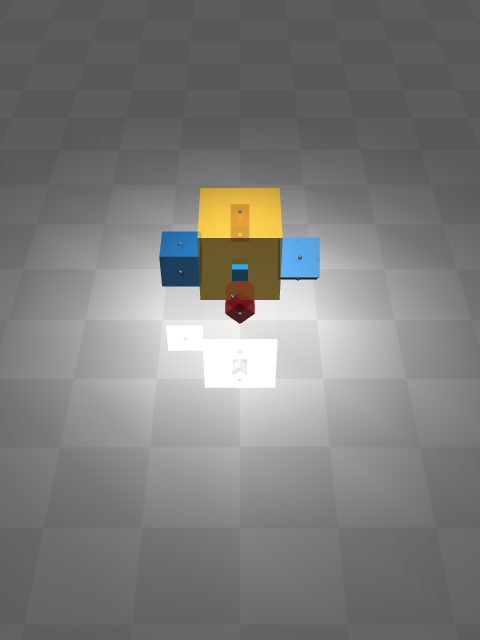

In [6]:
root = CanonicalNode.new_root()

print(root._axial_face_order)
print(root._radial_face_order)

root.LEFT = CanonicalNode("BRICK")
root.RIGHT = CanonicalNode("Brick", 1)
root.FRONT = CanonicalNode("hinge")
root.BACK = CanonicalNode("hinge", 1)

view(root.to_graph())

(<ModuleFaces.FRONT: 0>,)
(<ModuleFaces.BOTTOM: 5>, <ModuleFaces.LEFT: 3>, <ModuleFaces.TOP: 4>, <ModuleFaces.RIGHT: 2>)


           DoF (model.nv): 7, Actuators (model.nu): 1                                            ]8;id=904112;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=117539;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

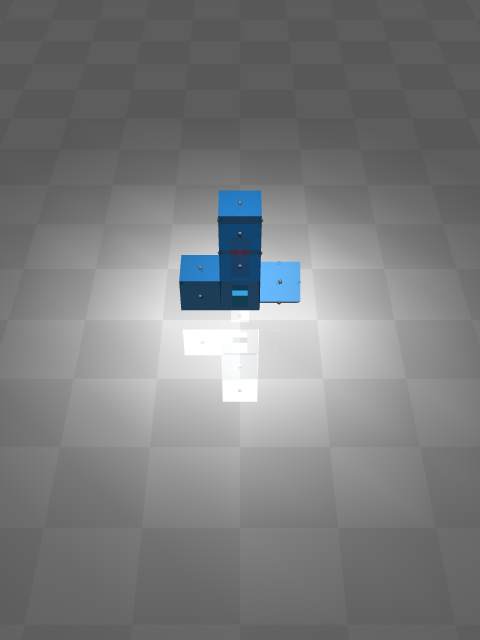

In [7]:
root = CanonicalNode.new_root("brick")

print(root._axial_face_order)
print(root._radial_face_order)

root.LEFT = CanonicalNode("BRICK")
root.RIGHT = CanonicalNode("Brick", 1)
root.FRONT = CanonicalNode("hinge")

root.TOP = CanonicalNode("BRICK")
root.TOP.FRONT = CanonicalNode("BRICK")

# root. = CanonicalNode("hinge", 1)

view(root.to_graph())

---

### Test

test with only hinges

           DoF (model.nv): 24, Actuators (model.nu): 18                                          ]8;id=767373;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=926655;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

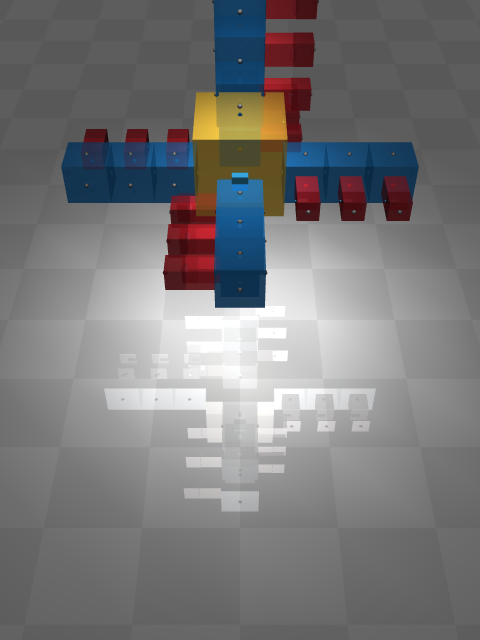

In [8]:
root = CanonicalNode.new_root()

hinge_placement = ModuleFaces.TOP
angle = 2

connector = CanonicalNode("brick", angle)
# connector.TOP = CanonicalNode("brick")
connector[hinge_placement] = CanonicalNode("hinge")

brickthing = CanonicalNode("brick" , 0)
# brickthing.TOP = CanonicalNode("brick")
brickthing[hinge_placement] = CanonicalNode("hinge")

connector.FRONT = brickthing
brickthing.FRONT = brickthing
# brickthing.FRONT.FRONT = brickthing

root.BACK = connector
root.LEFT = connector
root.TOP = connector
root.BOTTOM = connector
root.RIGHT = connector
root.FRONT = connector

view(root.to_graph(), with_viewer=False)

In [9]:
print(CanonicalNode("brick")._radial_face_order)

(<ModuleFaces.BOTTOM: 5>, <ModuleFaces.LEFT: 3>, <ModuleFaces.TOP: 4>, <ModuleFaces.RIGHT: 2>)


top, 6 <br>
right, 4 <br>
bottom, 2 <br>
left,   0

for brick: <br>

a rotation normalisation (-2 rotation) means list_items should shift backward (place of bottom should become place of left)

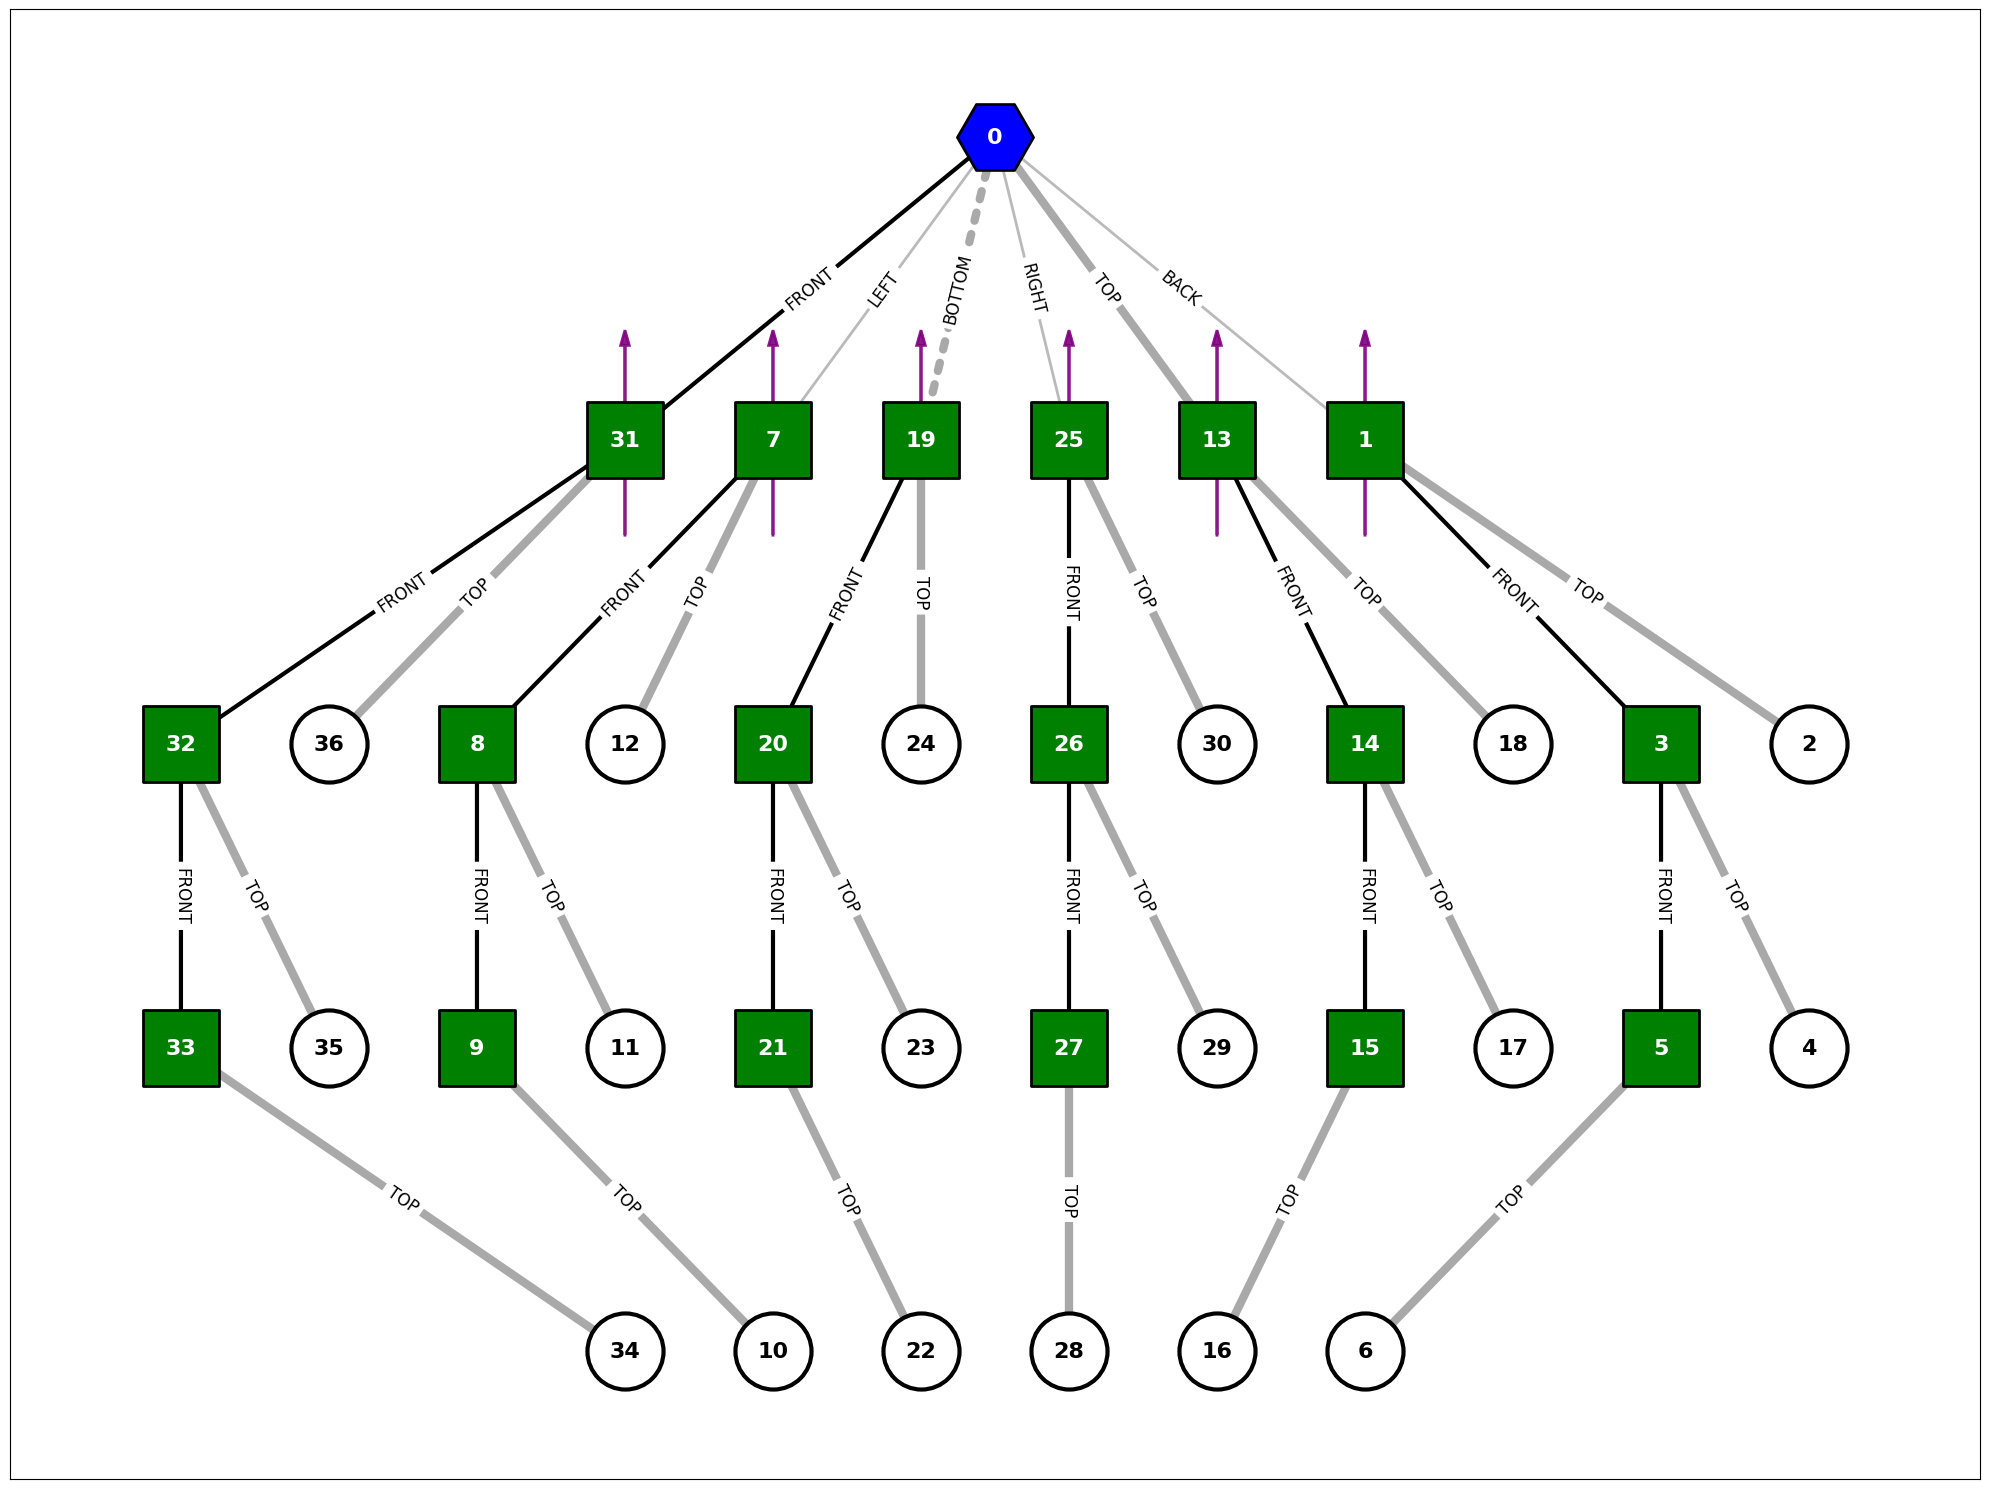

In [10]:
visualize_tree_from_graph(root.to_graph())

rotating 13
rotating 14
rotating 15
rotating 19
rotating 20
rotating 21
rotating 7
rotating 8
rotating 9
rotating 1
rotating 3
rotating 5
rotating 25
rotating 26
rotating 27
rotating 31
rotating 32
rotating 33



[23:56:11] DoF (model.nv): 24, Actuators (model.nu): 18                                          ]8;id=544013;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=588721;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

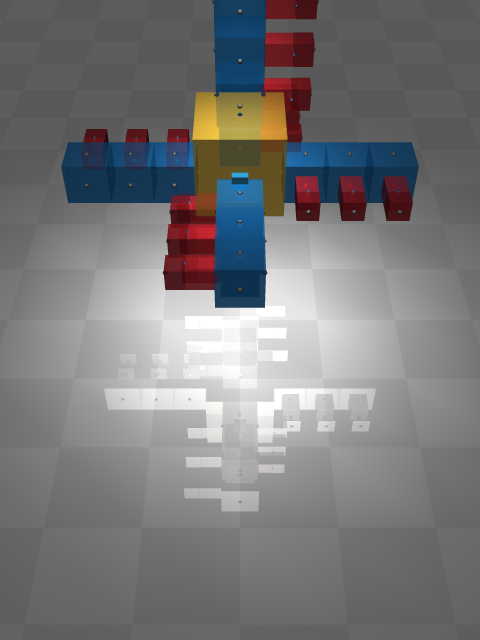

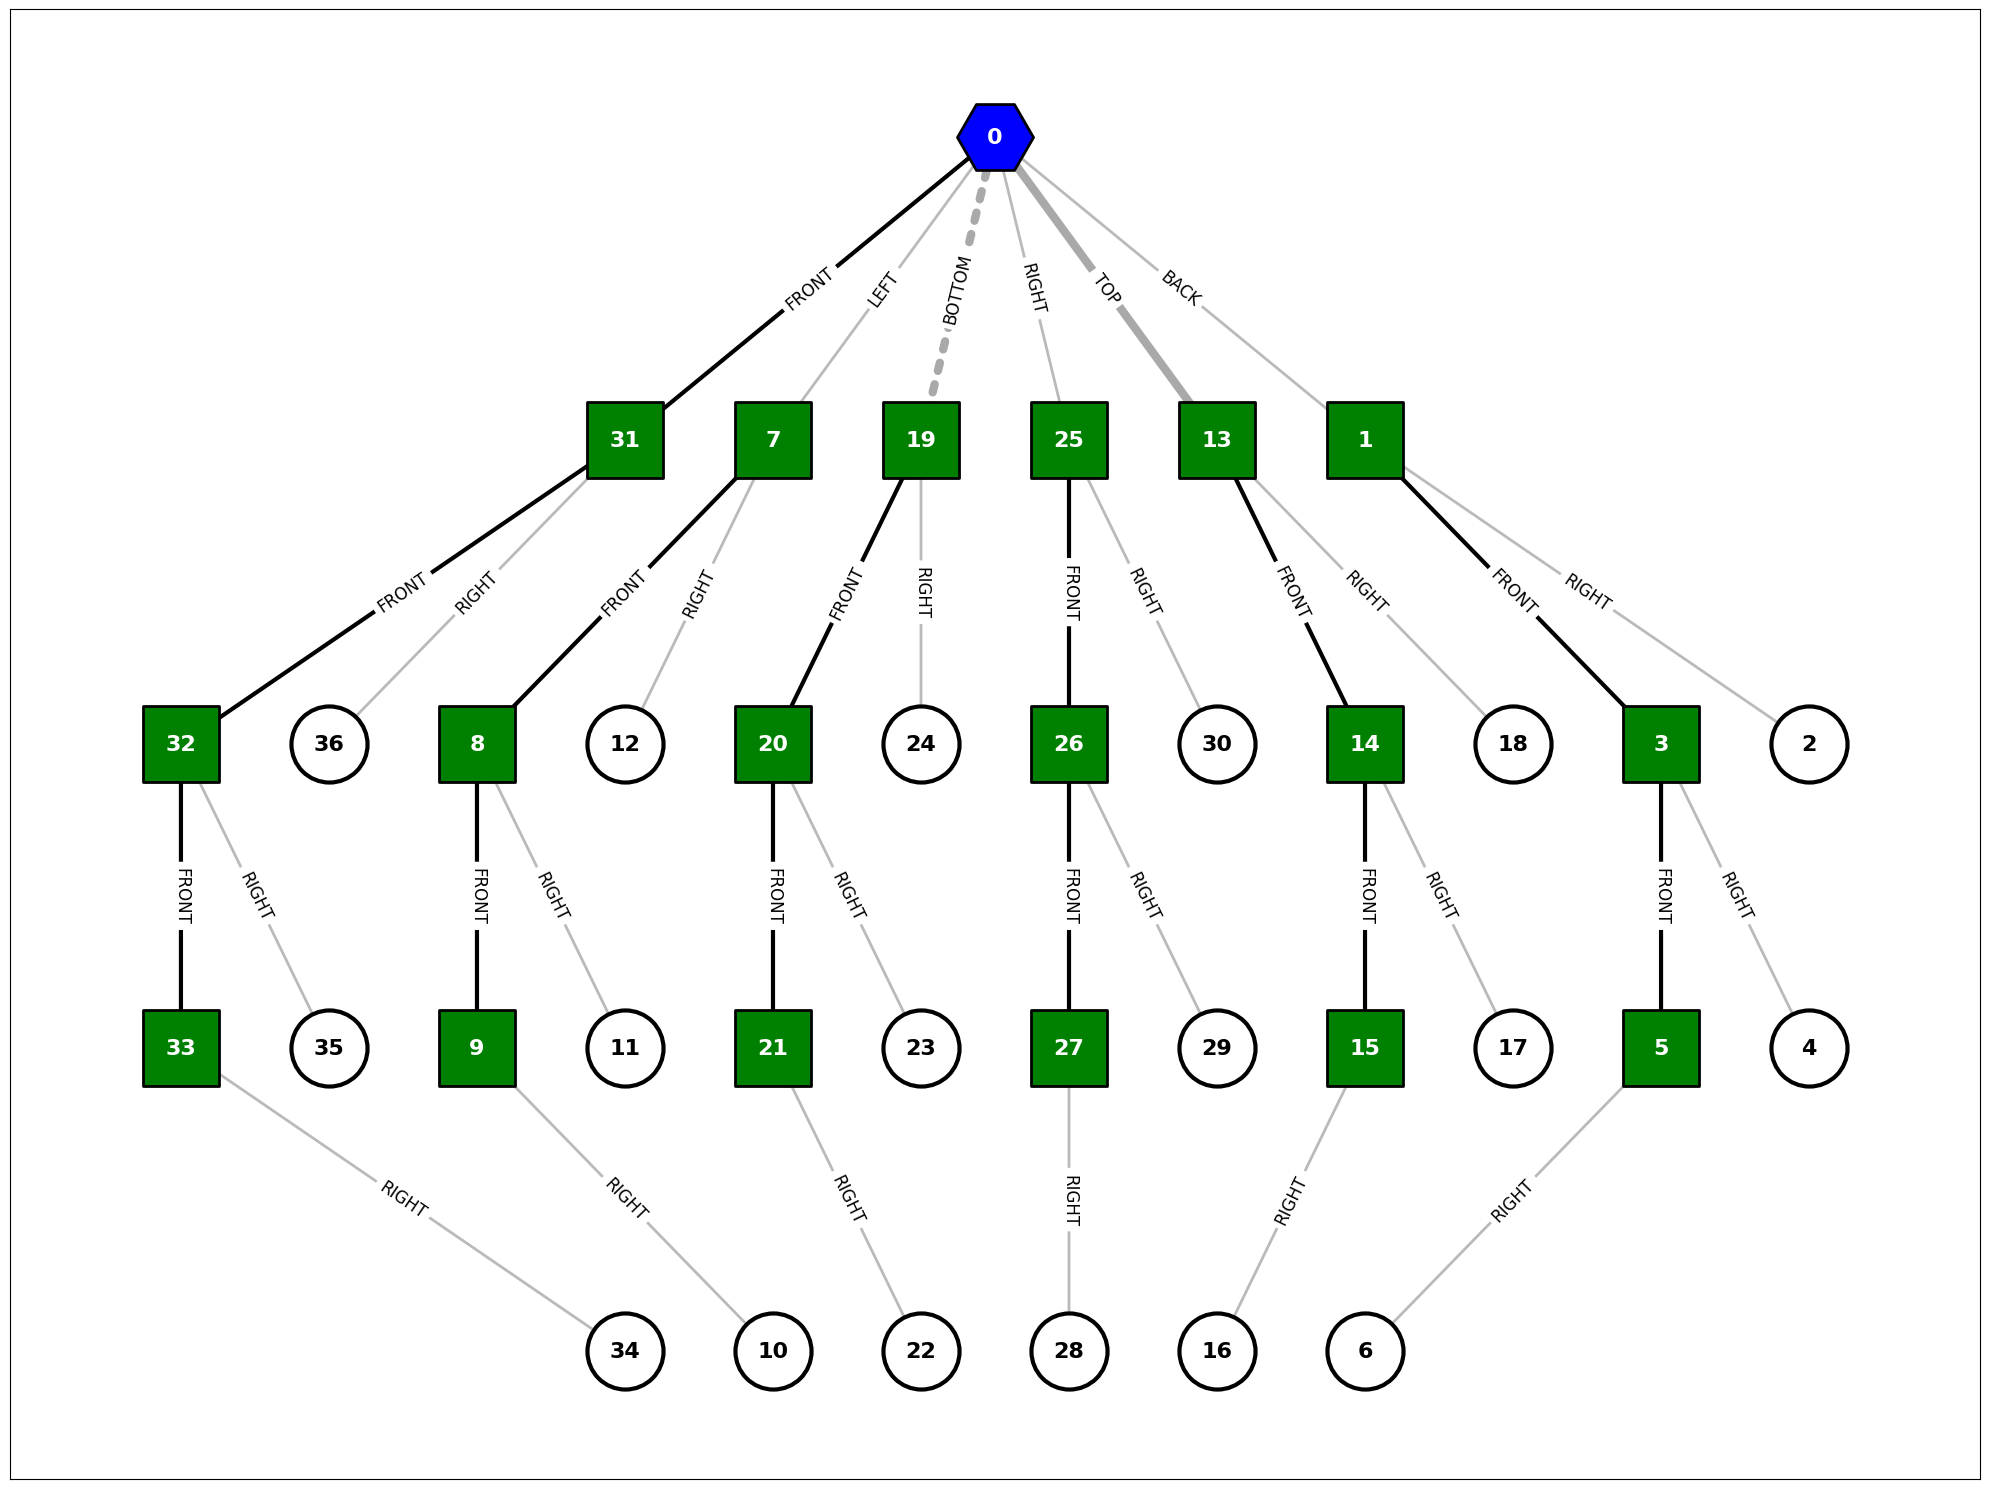

In [11]:
root.canonicalize()

view(root.to_graph())
visualize_tree_from_graph(root.to_graph())

test with brick and hinges

           DoF (model.nv): 48, Actuators (model.nu): 42                                          ]8;id=786021;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=546206;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

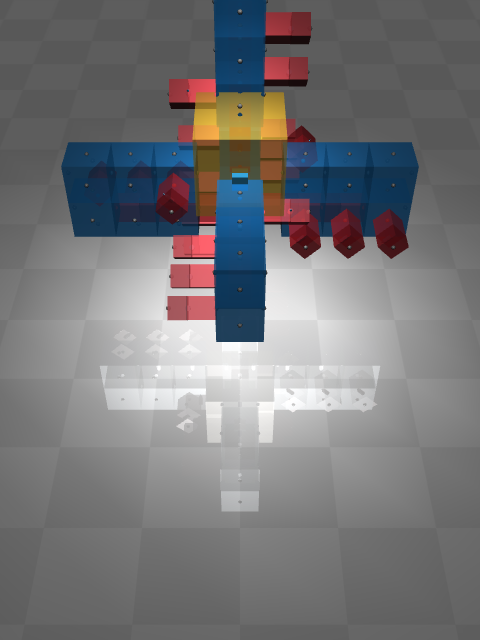

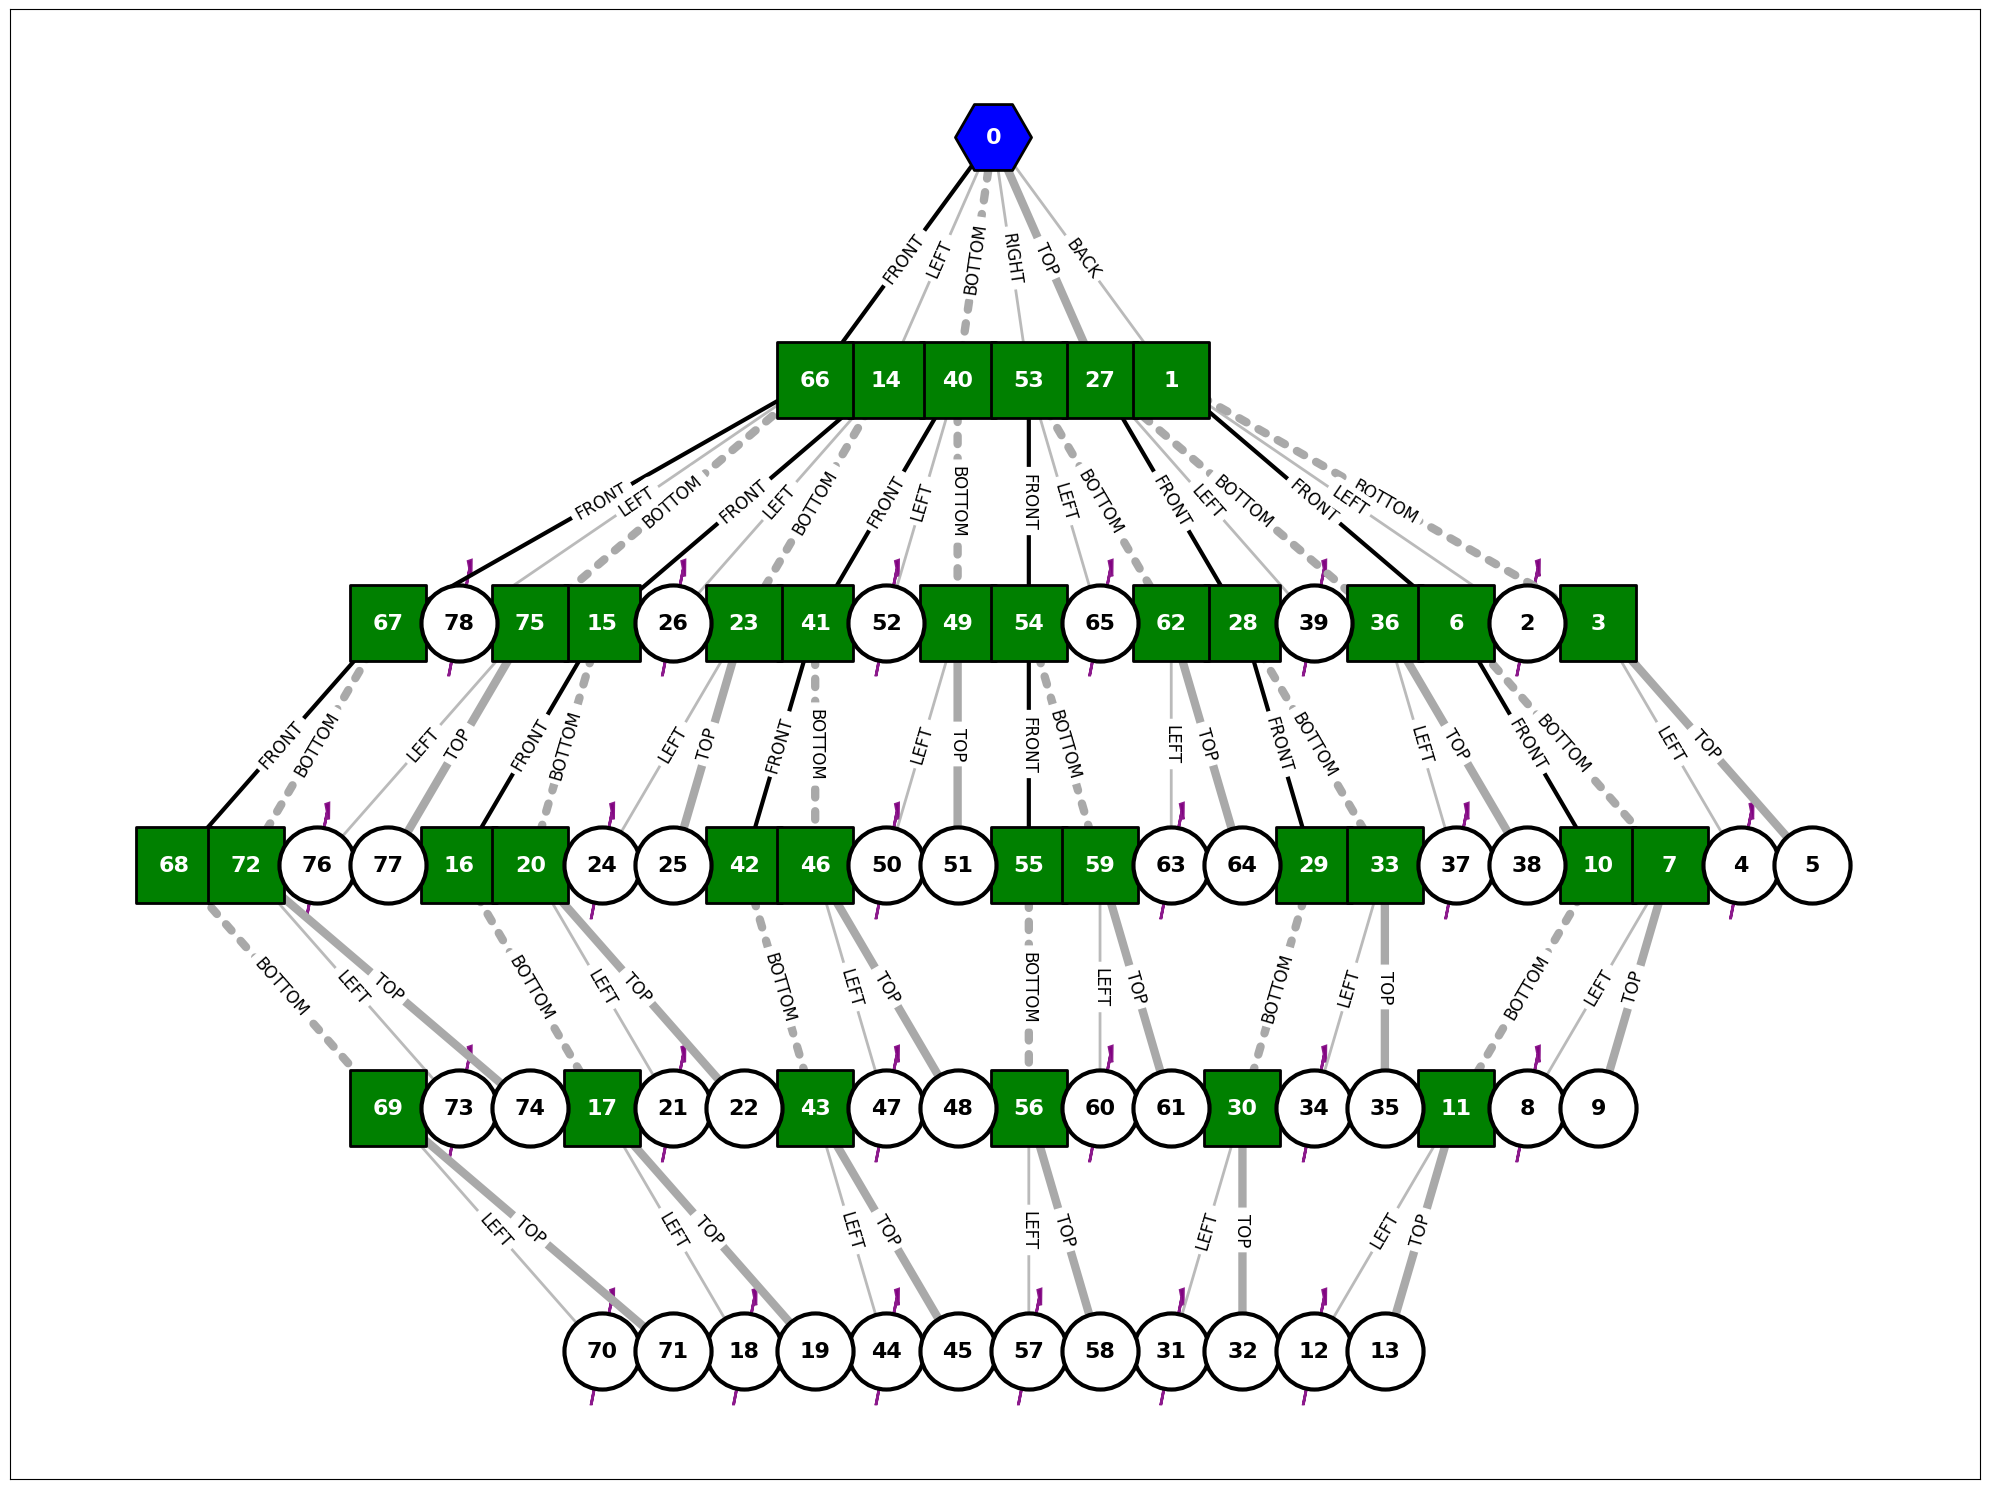

In [12]:
root = CanonicalNode.new_root()

hinge_placement = ModuleFaces.LEFT
angle = 0
connector = CanonicalNode("brick", angle)
connector.LEFT = CanonicalNode("hinge", 1)

connector.BOTTOM = CanonicalNode("brick")
connector.BOTTOM[hinge_placement] = CanonicalNode("hinge" , 1)
connector.BOTTOM.TOP = CanonicalNode("hinge", 0)

brickthing = CanonicalNode("brick" , 0)
brickthing.BOTTOM = CanonicalNode("brick")
brickthing.BOTTOM[hinge_placement] = CanonicalNode("hinge", 1)
brickthing.BOTTOM.TOP = CanonicalNode("hinge", 0)

connector.FRONT = brickthing
brickthing.FRONT = brickthing
# brickthing.FRONT.FRONT = brickthing

root.BACK = connector
root.LEFT = connector
root.TOP = connector
root.BOTTOM = connector
root.RIGHT = connector
root.FRONT = connector

view(root.to_graph(), with_viewer=True)
visualize_tree_from_graph(root.to_graph())

[23:56:19] DoF (model.nv): 48, Actuators (model.nu): 42                                          ]8;id=224691;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=736555;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

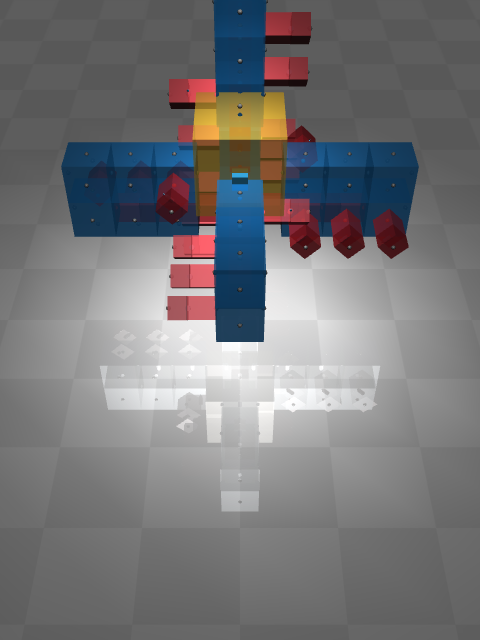

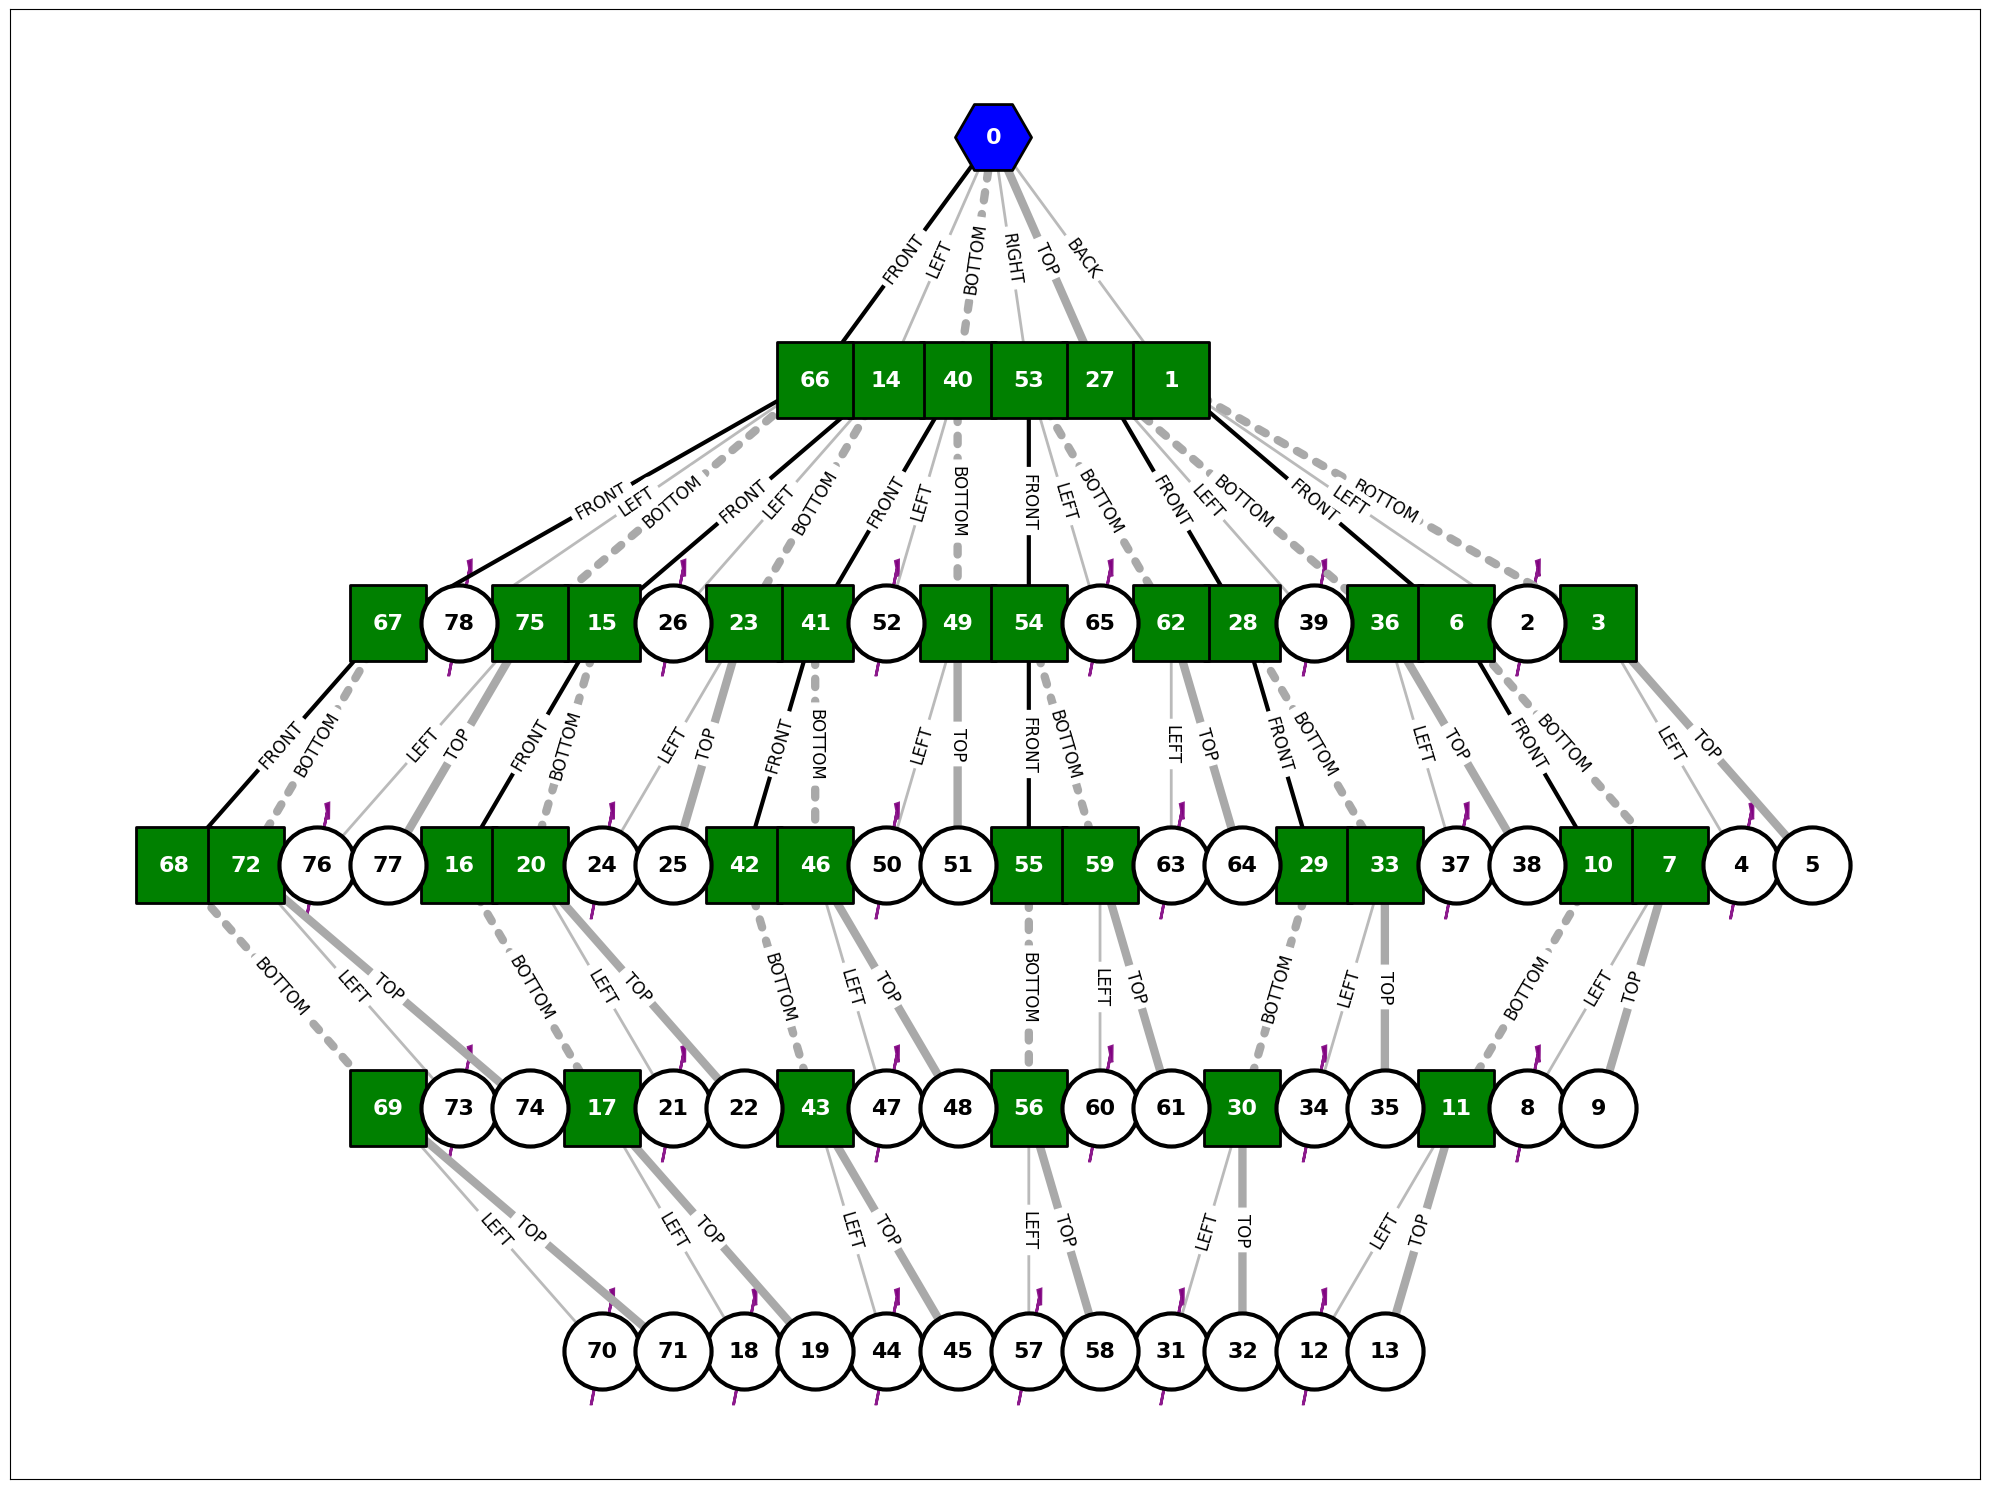

In [13]:
root.canonicalize()

view(root.to_graph())
visualize_tree_from_graph(root.to_graph())

(<ModuleFaces.BOTTOM: 5>, <ModuleFaces.LEFT: 3>, <ModuleFaces.TOP: 4>, <ModuleFaces.RIGHT: 2>)



[23:56:20] DoF (model.nv): 9, Actuators (model.nu): 3                                            ]8;id=210078;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=916769;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

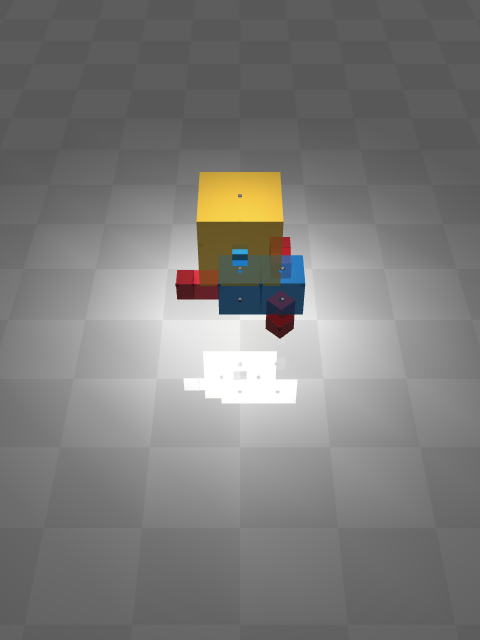

In [14]:
root = CanonicalNode.new_root()

brick1 = CanonicalNode("brick", 2)
# brick1.LEFT = CanonicalNode("hinge", 1)
brick1.TOP = CanonicalNode("hinge", 0)

brick2 = CanonicalNode("brick")
brick2.LEFT = CanonicalNode("hinge", 1)
brick2.TOP = CanonicalNode("hinge", 0)

brick1.BOTTOM = brick2

root.BACK = brick1
# root[placement].BOTTOM = brick # placement of the birck on brick

print(brick1._radial_face_order)

view(root.to_graph(), with_viewer=True)

(<ModuleFaces.BOTTOM: 5>, <ModuleFaces.LEFT: 3>, <ModuleFaces.TOP: 4>, <ModuleFaces.RIGHT: 2>)



[23:56:25] DoF (model.nv): 9, Actuators (model.nu): 3                                            ]8;id=385181;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=82693;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

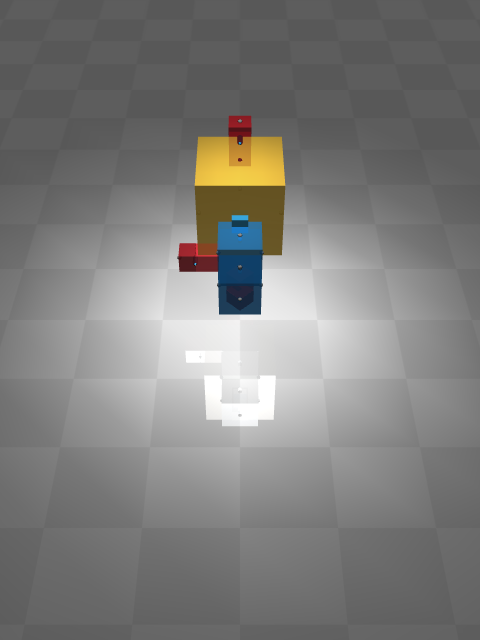

In [15]:
root = CanonicalNode.new_root()

brick1 = CanonicalNode("brick", 2)
# brick1.LEFT = CanonicalNode("hinge", 1)
# brick1.TOP = CanonicalNode("hinge", 0)

brick2 = CanonicalNode("brick")
# brick2.LEFT = CanonicalNode("hinge", 1)
# brick2.TOP = CanonicalNode("hinge", 0)


brick3 = CanonicalNode("BRICK")
brick3.LEFT = CanonicalNode("hinge", 1)
brick3.TOP = CanonicalNode("Hinge")

brick2.RIGHT = brick3

brick1.RIGHT = brick2

root.BACK = brick1

root.TOP = CanonicalNode("Hinge")
# root[placement].BOTTOM = brick # placement of the birck on brick

print(brick1._radial_face_order)

view(root.to_graph(), with_viewer=True)

In [ ]:
root = CanonicalNode.new_root()

brick1 = CanonicalNode("brick", 0)
brick1.LEFT = CanonicalNode("hinge", 1)
brick1.TOP = CanonicalNode("hinge", 0)

# brick2 = CanonicalNode("brick")
# brick2.LEFT = CanonicalNode("hinge", 1)
# brick2.TOP = CanonicalNode("hinge", 0)


# brick3 = CanonicalNode("BRICK")
# brick3.LEFT = CanonicalNode("hinge", 1)
# brick3.TOP = CanonicalNode("Hinge")

# brick2.RIGHT = brick3

# brick1.RIGHT = brick2

root.BOTTOM = brick1

# root.TOP = CanonicalNode("Hinge")
# root[placement].BOTTOM = brick # placement of the birck on brick

# print(root._radial_face_order)

view(root.to_graph(), with_viewer=True)

[23:56:34] DoF (model.nv): 8, Actuators (model.nu): 2                                            ]8;id=91110;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=759625;file:///Users/salomepoulain/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\